In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms
from torch.utils.data import DataLoader
import pdb
import torch.optim as optim
import tqdm

In [2]:
from datasets import PollyClassificationDataset
from models_classification import AudioResnet34
import main
from CenterLoss import CenterLoss

## Get data

In [19]:
train_dataset = PollyClassificationDataset(recordingsPath='PollyClassificationData/train')
test_dataset  = PollyClassificationDataset(recordingsPath='PollyClassificationData/test')

Tranform applied to data is: Spectrogram()
Tranform applied to data is: Spectrogram()


In [20]:
len(train_dataset), len(test_dataset)

(46600, 11648)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, pin_memory = True)
test_dataloader  = DataLoader(test_dataset,  batch_size = 64, shuffle = True, pin_memory = True)

20028
torch.Size([201, 251])


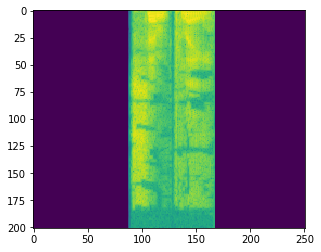

In [6]:
def display_random_specgm():
    random_index = np.random.randint(0,len(train_dataset))
    print(random_index)
    signal, _ = train_dataset[random_index]
    print(signal.squeeze().shape)
    plt.imshow(signal.squeeze())
display_random_specgm()

## Define Model

In [7]:
logger = main.Logger('AudioResnet34')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = AudioResnet34(1, len(set(train_dataset.audioFileLabels)), logger = logger)
model.to(device)

AudioResnet34(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (

In [9]:
print(torch.cuda.is_available())
print(device)
print(torch.cuda.current_device(), torch.cuda.get_device_name())

True
cuda:0
0 Tesla T4


In [10]:
epochs = 30
criterion = nn.CrossEntropyLoss()
center_loss = CenterLoss(num_classes=len(set(train_dataset.audioFileLabels)), 
                         feat_dim=len(set(train_dataset.audioFileLabels)),
                        use_gpu = torch.cuda.is_available())

params = list(model.parameters()) + list(center_loss.parameters())
optimizer = optim.Adam(params, lr=1e-3, weight_decay=5e-3)

In [11]:
def learn(epoch, model, trainloader):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    alpha = 0.5 # center loss weight
    
    for i, data in (enumerate(trainloader)):
        # get input and labels
        x, y = data[0].to(device), data[1].to(device)
        
        # clear out past gradients
        optimizer.zero_grad()
        
        # forward pass
        yhat = model(x)
        ce_loss = criterion(yhat, y)
        
        # combine using centre loss and CE loss
        loss = alpha * center_loss(yhat, y) + ce_loss
        
        # backward step
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1. / alpha)
        
        # update parameters
        optimizer.step()
        
        _, predicted = torch.max(yhat.data, 1)
        total   += y.size(0)
        correct += (predicted == y).sum().item()
        all_predictions.extend(list(map(lambda t: t.item(), predicted)))
        
        running_loss += loss.item()
        
        logging_interval = 20
        if ((i+1) % logging_interval == 0):
            feedback_string = 'epoch #{:2} \t batch #{:3} \t loss {:.3f} \t accuracy {:.3f}'
            print(feedback_string.format(epoch, i+1, running_loss/logging_interval, 100 * correct / total))
            model.logger.log_training(running_loss/logging_interval, 100 * correct / total)
            
#             if ((i+1) % (logging_interval*10)) == 0:
#                 counts = {}
#                 for i in all_predictions: counts[i] = 1 + counts.get(i, 0)
#                 print('counts in training are:', sorted(counts.items()))

            
            running_loss = 0.0
            correct = 0
            total = 0
            


def validate(epoch, model, dataloader):
    model.eval()
    
    correct = 0
    total = 0
    total_loss = 0.0
    all_predictions = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            total_loss += criterion(outputs, labels) + 0.5 * center_loss(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(list(map(lambda x: x.item(), predicted)))
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    num_batches = total/dataloader.batch_size
    model.logger.log_validation(total_loss.item()/num_batches, 100 * correct / total)
    print('After epoch {}, validation loss={:.3f} and accuracy={:.2f}'.format(epoch, 
                                                  total_loss.item()/num_batches, 100 * correct / total))

    
    counts = {}
    for i in all_predictions: counts[i] = 1 + counts.get(i, 0)
#     print('counts in validation are:', sorted(counts.items()))



In [18]:
def train():
    for epoch in tqdm.tqdm(range(4,epochs+1)):
        # train for an epoch
        learn(epoch, model, train_dataloader)
        # validate 
        validate(epoch, model, test_dataloader)
        # save the model
        if epoch%3 == 0: model.save_model(optimizer)
        # display graphs
        if epoch%3 == 0: model.display_training_graphs()

In [19]:
train()


  0%|          | 0/27 [00:00<?, ?it/s]

epoch # 4 	 batch # 20 	 loss 0.344 	 accuracy 98.516
epoch # 4 	 batch # 40 	 loss 0.317 	 accuracy 99.219
epoch # 4 	 batch # 60 	 loss 0.306 	 accuracy 99.766
epoch # 4 	 batch # 80 	 loss 0.312 	 accuracy 98.984
epoch # 4 	 batch #100 	 loss 0.311 	 accuracy 99.219
epoch # 4 	 batch #120 	 loss 0.322 	 accuracy 98.984
epoch # 4 	 batch #140 	 loss 0.300 	 accuracy 99.141
epoch # 4 	 batch #160 	 loss 0.297 	 accuracy 99.297
epoch # 4 	 batch #180 	 loss 0.304 	 accuracy 98.750
epoch # 4 	 batch #200 	 loss 0.294 	 accuracy 99.141
epoch # 4 	 batch #220 	 loss 0.290 	 accuracy 99.219
epoch # 4 	 batch #240 	 loss 0.286 	 accuracy 98.906
epoch # 4 	 batch #260 	 loss 0.288 	 accuracy 99.141
epoch # 4 	 batch #280 	 loss 0.317 	 accuracy 97.969
CAUGHT EXCEPTION: couldn't open filePollyClassificationData/train/us/doom-metal_us.mp3. Going to return empty tensor
epoch # 4 	 batch #300 	 loss 0.288 	 accuracy 99.297
CAUGHT EXCEPTION: couldn't open filePollyClassificationData/train/us/inte


  4%|▎         | 1/27 [09:45<4:13:48, 585.70s/it]

After epoch 4, validation loss=0.302 and accuracy=99.19
epoch # 5 	 batch # 20 	 loss 0.242 	 accuracy 99.219
epoch # 5 	 batch # 40 	 loss 0.240 	 accuracy 99.219
epoch # 5 	 batch # 60 	 loss 0.216 	 accuracy 99.766
epoch # 5 	 batch # 80 	 loss 0.209 	 accuracy 99.844
epoch # 5 	 batch #100 	 loss 0.223 	 accuracy 99.219
epoch # 5 	 batch #120 	 loss 0.209 	 accuracy 99.688
epoch # 5 	 batch #140 	 loss 0.222 	 accuracy 99.297
epoch # 5 	 batch #160 	 loss 0.205 	 accuracy 99.766
epoch # 5 	 batch #180 	 loss 0.227 	 accuracy 99.375
CAUGHT EXCEPTION: couldn't open filePollyClassificationData/train/us/birthday.Several_us.mp3. Going to return empty tensor
epoch # 5 	 batch #200 	 loss 0.236 	 accuracy 99.219
epoch # 5 	 batch #220 	 loss 0.208 	 accuracy 99.531
epoch # 5 	 batch #240 	 loss 0.214 	 accuracy 99.141
epoch # 5 	 batch #260 	 loss 0.226 	 accuracy 99.141
epoch # 5 	 batch #280 	 loss 0.215 	 accuracy 99.297
epoch # 5 	 batch #300 	 loss 0.195 	 accuracy 99.609
epoch # 5 	


  7%|▋         | 2/27 [19:27<4:03:36, 584.65s/it]

After epoch 5, validation loss=3.039 and accuracy=50.00
epoch # 6 	 batch # 20 	 loss 0.178 	 accuracy 99.453
epoch # 6 	 batch # 40 	 loss 0.207 	 accuracy 99.141
epoch # 6 	 batch # 60 	 loss 0.233 	 accuracy 99.375
epoch # 6 	 batch # 80 	 loss 0.195 	 accuracy 99.531
epoch # 6 	 batch #100 	 loss 0.176 	 accuracy 99.688
epoch # 6 	 batch #120 	 loss 0.188 	 accuracy 99.375
epoch # 6 	 batch #140 	 loss 0.162 	 accuracy 99.844
epoch # 6 	 batch #160 	 loss 0.158 	 accuracy 99.922
epoch # 6 	 batch #180 	 loss 0.155 	 accuracy 99.844
epoch # 6 	 batch #200 	 loss 0.227 	 accuracy 98.984
CAUGHT EXCEPTION: couldn't open filePollyClassificationData/train/us/inter-Korean_us.mp3. Going to return empty tensor
epoch # 6 	 batch #220 	 loss 0.163 	 accuracy 99.844
epoch # 6 	 batch #240 	 loss 0.155 	 accuracy 100.000
epoch # 6 	 batch #260 	 loss 0.201 	 accuracy 99.062
epoch # 6 	 batch #280 	 loss 0.177 	 accuracy 99.609
epoch # 6 	 batch #300 	 loss 0.183 	 accuracy 99.453
epoch # 6 	 ba


 11%|█         | 3/27 [29:03<3:52:48, 582.03s/it]

epoch # 7 	 batch # 20 	 loss 0.146 	 accuracy 99.844
epoch # 7 	 batch # 40 	 loss 0.154 	 accuracy 99.766
epoch # 7 	 batch # 60 	 loss 0.140 	 accuracy 100.000
epoch # 7 	 batch # 80 	 loss 0.199 	 accuracy 99.375
CAUGHT EXCEPTION: couldn't open filePollyClassificationData/train/us/birthday.Several_us.mp3. Going to return empty tensor
epoch # 7 	 batch #100 	 loss 0.143 	 accuracy 99.766
epoch # 7 	 batch #120 	 loss 0.162 	 accuracy 99.609
epoch # 7 	 batch #140 	 loss 0.159 	 accuracy 99.609
CAUGHT EXCEPTION: couldn't open filePollyClassificationData/train/us/inter-Korean_us.mp3. Going to return empty tensor
epoch # 7 	 batch #160 	 loss 0.144 	 accuracy 100.000
epoch # 7 	 batch #180 	 loss 0.147 	 accuracy 99.922
epoch # 7 	 batch #200 	 loss 0.134 	 accuracy 99.922
epoch # 7 	 batch #220 	 loss 0.147 	 accuracy 99.609
epoch # 7 	 batch #240 	 loss 0.170 	 accuracy 99.688
epoch # 7 	 batch #260 	 loss 0.155 	 accuracy 99.609
epoch # 7 	 batch #280 	 loss 0.206 	 accuracy 99.219



 15%|█▍        | 4/27 [38:34<3:41:48, 578.62s/it]

After epoch 7, validation loss=0.123 and accuracy=99.54
epoch # 8 	 batch # 20 	 loss 0.157 	 accuracy 99.531
epoch # 8 	 batch # 40 	 loss 0.133 	 accuracy 99.922
epoch # 8 	 batch # 60 	 loss 0.136 	 accuracy 99.766
epoch # 8 	 batch # 80 	 loss 0.150 	 accuracy 99.688
epoch # 8 	 batch #100 	 loss 0.137 	 accuracy 99.844
CAUGHT EXCEPTION: couldn't open filePollyClassificationData/train/us/birthday.Several_us.mp3. Going to return empty tensor
epoch # 8 	 batch #120 	 loss 0.141 	 accuracy 99.766
epoch # 8 	 batch #140 	 loss 0.129 	 accuracy 100.000
epoch # 8 	 batch #160 	 loss 0.124 	 accuracy 99.922
epoch # 8 	 batch #180 	 loss 0.119 	 accuracy 100.000
epoch # 8 	 batch #200 	 loss 0.123 	 accuracy 100.000
epoch # 8 	 batch #220 	 loss 0.182 	 accuracy 99.375
epoch # 8 	 batch #240 	 loss 0.193 	 accuracy 99.453
epoch # 8 	 batch #260 	 loss 0.163 	 accuracy 99.453
epoch # 8 	 batch #280 	 loss 0.163 	 accuracy 99.688
epoch # 8 	 batch #300 	 loss 0.128 	 accuracy 99.844
epoch # 


 19%|█▊        | 5/27 [48:02<3:31:01, 575.54s/it]

After epoch 8, validation loss=0.232 and accuracy=99.75
epoch # 9 	 batch # 20 	 loss 0.177 	 accuracy 99.688


KeyboardInterrupt: 

In [21]:
model.save_model(optimizer)

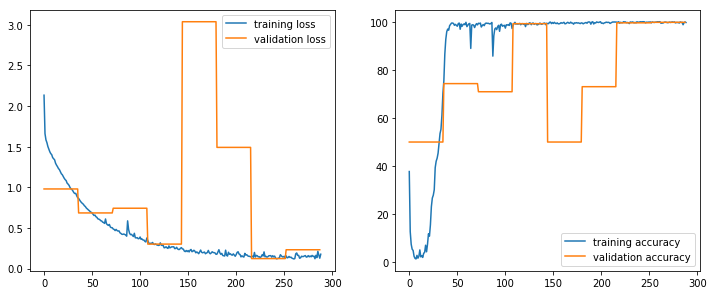

In [22]:
def plot_batch_stats():
    plt.figure("Batch loss and accuracy", figsize=(4.8*2.5, 4.8))
    
    def plot_losses():
        ratio = int(len(model.logger.training_loss)/len(model.logger.validation_loss))
        l = [ [i]*ratio for i in model.logger.validation_loss ]
        adjusted_validation_loss = []
        for e in l: adjusted_validation_loss.extend(e)
            
        plt.figure("Batch loss and accuracy")
        plt.subplot(121)
        plt.plot(model.logger.training_loss, label = 'training loss')
        plt.plot(adjusted_validation_loss, label = 'validation loss')
        plt.legend()
        
    def plot_accuracies():
        ratio = int(len(model.logger.training_accuracy)/len(model.logger.validation_accuracy))        
        l = [ [i]*ratio for i in model.logger.validation_accuracy ]
        adjusted_validation_acc = []
        for e in l: adjusted_validation_acc.extend(e)
            
        plt.figure("Batch loss and accuracy")
        plt.subplot(122)
        plt.plot(model.logger.training_accuracy, label = 'training accuracy')
        plt.plot(adjusted_validation_acc, label = 'validation accuracy')
        plt.legend()

    plot_losses()
    plot_accuracies()
#     plt.show("Batch loss and accuracy")
plot_batch_stats()

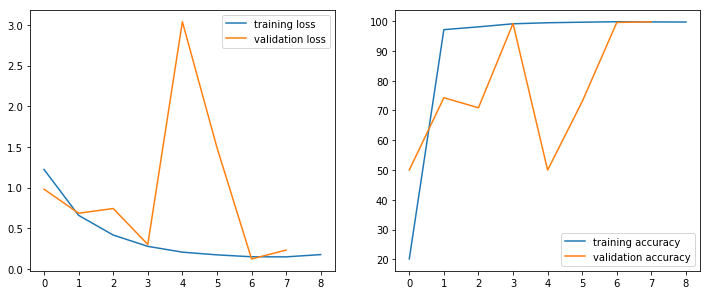

In [23]:
def plot_epoch_stats():

    plt.figure("Epoch loss and accuracies", figsize=(4.8*2.5, 4.8))

    def plot_losses_epoch():
        ratio = int(len(model.logger.training_loss)/len(model.logger.validation_loss))
        l = [ model.logger.training_loss[i:i+ratio] for i in range(0,len(model.logger.training_loss),ratio) ]
        adjusted_training_loss = []
        for e in l: adjusted_training_loss.append(sum(e)/len(e))

        plt.figure("Epoch loss and accuracies")
        plt.subplot(121)
        plt.plot(adjusted_training_loss, label = 'training loss')
        plt.plot(model.logger.validation_loss, label = 'validation loss')
        plt.legend()


    def plot_acc_epoch():
        ratio = int(len(model.logger.training_accuracy)/len(model.logger.validation_accuracy))
        l = [ model.logger.training_accuracy[i:i+ratio] for i in range(0,len(model.logger.training_accuracy),ratio) ]
        adjusted_training_acc = []
        for e in l: adjusted_training_acc.append(sum(e)/len(e))
            
        plt.figure("Epoch loss and accuracies")
        plt.subplot(122)
        plt.plot(adjusted_training_acc, label = 'training accuracy')
        plt.plot(model.logger.validation_accuracy, label = 'validation accuracy')
        plt.legend()
    
    plot_acc_epoch()
    plot_losses_epoch()

plot_epoch_stats()

In [24]:
from sklearn.manifold import TSNE

In [22]:
def get_test_data():
    model.eval()
    X = torch.Tensor().to(device)
    Y = torch.zeros(()).new_empty(0, dtype=torch.int, device = device)
    
    with torch.no_grad():
        for data in test_dataloader:
            x, y = data
            x, y = x.to(device), y.to(device).int()
            outputs = model(x)
            X = torch.cat((X, outputs), dim=0)
            Y = torch.cat((Y, y), dim=0)
    return X, Y

print(get_test_data()[1][:10])

tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0', dtype=torch.int32)


In [26]:
def get_embeddings():
    '''
    iterate over test dataloader
    get forward embeddings
    stack embeddings
    use t-sne
    '''
    print("getting embeddings...")
    X, Y = get_test_data()
    X, Y = X.cpu().numpy(), Y.cpu().numpy()
    print("getting projections...")
    projector = TSNE(n_components=2, perplexity=15, learning_rate=10)
    projections = projector.fit_transform(X)
    print("done.")
    return projections, Y

projections, Y = get_embeddings()

getting embeddings...
getting projections...
done.


In [27]:
Y

array([0, 1, 0, ..., 1, 1, 0], dtype=int32)

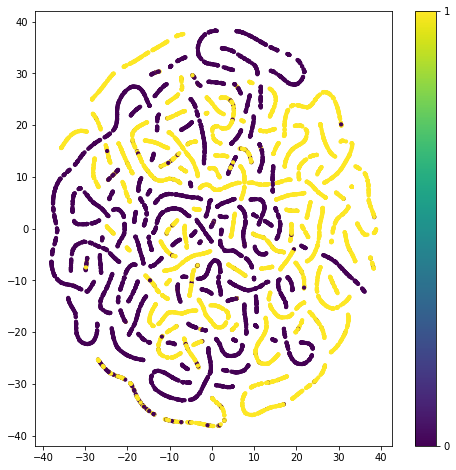

In [28]:
def show_projections(projections, y):
    
    # plot the result
    vis_x = projections[:, 0]
    vis_y = projections[:, 1]

    plt.figure('TSNE Projections', figsize=(8,8))
    plt.scatter(vis_x, vis_y, c=y, s=10)
    plt.colorbar(ticks=range(len(set(y))))
#     plt.clim(-0.5, 9.5)
    plt.show()
#     plt.legend(set(y))
show_projections(projections, Y)


In [ ]:
def check_loading_works():
    '''
    check if loading old saved models works
    '''
    newLogger_test = main.Logger("AudioResNet")
    newModel_test = models.AudioResnet34(1, len(train_dataset.idx_to_labels),logger=newLogger_test)
    newOptimizer_test = optim.Adam(list(newModel_test.parameters()) + list(CenterLoss(18, 18).parameters()))
    
    newModel_test.load_saved_model('./SavedModels/AudioResnet34_epoch21_accuracy85.pt', newOptimizer_test)
    print('done.')
    pdb.set_trace()
    newModel_test.parameters()
check_loading_works()   

In [ ]:
list(model.parameters())[].shape

In [ ]:
summary(model)

In [29]:
sum([param.nelement() for param in model.parameters()])

21304216

In [4]:
logger = main.Logger('AudioResnet34')
model = AudioResnet34(input_channels=1, num_classes=2, logger=logger)

criterion = nn.CrossEntropyLoss()
center_loss = CenterLoss(num_classes=len(set(train_dataset.audioFileLabels)), 
                         feat_dim=len(set(train_dataset.audioFileLabels)),
                        use_gpu = torch.cuda.is_available())
params = list(model.parameters()) + list(center_loss.parameters())
optimizer = optim.Adam(params, lr=1e-3, weight_decay=5e-3)
model.load_saved_model('./SavedModels/AudioResnet34_epoch8_accuracy99.pt', optimizer)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

AudioResnet34(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (

In [17]:
import random
import IPython.display as ipd
random.seed(42)

def sanity_check():
#     pdb.set_trace()
    model.eval()
    train_examples = random.sample( list(range(len(train_dataset))), 15 )
    test_examples  = random.sample( list(range(len(test_dataset))), 15 )
    
    print("TRAINING EXAMPLES")
    with torch.no_grad():
        for i in train_examples:
            audio_wave, speaker = train_dataset.getAudio(i) # gives audio waveform
            net_input, _ = train_dataset[i] # gives spectrogram
            net_input = net_input.to(device).unsqueeze(0)
            prediction = model(net_input)
            prediction = torch.max(prediction, 1)[1].item()
            prediction = train_dataset.idx_to_labels[prediction]
            ipd.display(ipd.Audio(audio_wave.numpy(), rate=22050))
            print("gt={}, predicted={}\n\n".format(train_dataset.idx_to_labels[speaker], prediction))

        print("\n\n\n\nTEST EXAMPLES")
        for i in test_examples:
            audio_wave, speaker = test_dataset.getAudio(i) # gives audio waveform
            net_input, _ = test_dataset[i] # gives spectrogram
            net_input = net_input.to(device).unsqueeze(0)
            prediction = model(net_input)
            prediction = torch.max(prediction, 1)[1].item()
            prediction = test_dataset.idx_to_labels[prediction]
            ipd.display(ipd.Audio(audio_wave.numpy(), rate=22050))
            print("gt={}, predicted={}\n\n".format(test_dataset.idx_to_labels[speaker], prediction))

sanity_check()

TRAINING EXAMPLES


gt=us, predicted=us




gt=uk, predicted=us




gt=uk, predicted=us




gt=uk, predicted=uk




gt=uk, predicted=uk




gt=uk, predicted=us




gt=uk, predicted=us




gt=uk, predicted=us




gt=us, predicted=us




gt=us, predicted=us




gt=uk, predicted=us




gt=us, predicted=us




gt=us, predicted=us




gt=uk, predicted=uk




gt=uk, predicted=uk






TEST EXAMPLES


gt=uk, predicted=us




gt=uk, predicted=uk




gt=uk, predicted=uk




gt=us, predicted=us




gt=us, predicted=us




gt=uk, predicted=uk




gt=us, predicted=us




gt=uk, predicted=uk




gt=us, predicted=us




gt=us, predicted=us




gt=us, predicted=us




gt=us, predicted=us




gt=uk, predicted=uk




gt=us, predicted=us




gt=us, predicted=us


